In [1]:
%config Completer.use_jedi = False

import sys
sys.path.append('..')

import os
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

use_cpu = False
cuda_device = '0'

if use_cpu:
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
    os.environ['CPU_ONLY'] = "TRUE"
    physical_devices = tf.config.list_physical_devices('CPU')
    tf.config.set_logical_device_configuration(
        physical_devices[0],
        [tf.config.LogicalDeviceConfiguration() for i in range(8)])
    logical_devices = tf.config.list_logical_devices('CPU')

    print(logical_devices)
else:
    os.environ['CUDA_VISIBLE_DEVICES'] = cuda_device
    os.environ['CPU_ONLY'] = "FALSE"
    physical_devices = tf.config.list_physical_devices('GPU')
    print(physical_devices)
    
from collections import defaultdict
from sklearn.metrics import r2_score
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import h5py

from tndm.data import DataManager
from tndm import DA
from tndm.runtime import Runtime, ModelType
from tndm.utils import AdaptiveWeights
from tndm.models.model_loader import ModelLoader

from plotting import *

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
def load_data(train_files, test_files):
    for f in train_files:
        print(f['train_data'].shape)
    len_trial = min([f['train_data'].shape[1] for f in train_files + test_files])
    num_neurons = min([f['train_data'].shape[2] for f in train_files + test_files])
    
    train_data = np.concatenate(np.array([f['train_data'][:, :len_trial, :num_neurons] for f in train_files]))
    valid_data = np.concatenate(np.array([f['valid_data'][:, :len_trial, :num_neurons] for f in train_files]))
    test_data = np.concatenate(np.array([f['test_data'][:, :len_trial, :num_neurons] for f in train_files]))
    train_data_all = np.concatenate((train_data, valid_data, test_data))
    
    train_data = np.concatenate(np.array([f['train_data'][:, :len_trial, :num_neurons] for f in test_files]))
    valid_data = np.concatenate(np.array([f['valid_data'][:, :len_trial, :num_neurons] for f in test_files]))
    test_data = np.concatenate(np.array([f['test_data'][:, :len_trial, :num_neurons] for f in test_files]))
    test_data_all = np.concatenate((train_data, valid_data, test_data))
    
    
    train_target = np.concatenate(np.array([f['train_target_direction'][:] for f in train_files]))    
    valid_target = np.concatenate(np.array([f['valid_target_direction'][:] for f in train_files]))
    test_target = np.concatenate(np.array([f['test_target_direction'][:] for f in train_files]))
    train_target_all = np.concatenate((train_target, valid_target, test_target))
    
    train_target = np.concatenate(np.array([f['train_target_direction'][:] for f in test_files]))    
    valid_target = np.concatenate(np.array([f['valid_target_direction'][:] for f in test_files]))
    test_target = np.concatenate(np.array([f['test_target_direction'][:] for f in test_files]))
    test_target_all = np.concatenate((train_target, valid_target, test_target))
    

    #mean_xy = np.array([0,0])
    #offsets = []
    #for m in train_files:
    #    offsets.append(np.mean(mean_xy - m['train_behaviours'][:, 0], axis = 0))
    train_behaviours = np.concatenate(np.array([f['train_behaviours'][:, :len_trial] for i, f in enumerate(train_files)]))
    valid_behaviours = np.concatenate(np.array([f['valid_behaviours'][:, :len_trial]   for i, f in enumerate(train_files)]))
    test_behaviours = np.concatenate(np.array([f['test_behaviours'][:, :len_trial] for i, f in enumerate(train_files)]))
    train_behaviours_all = np.concatenate((train_behaviours, valid_behaviours, test_behaviours))
    
    # offsets = []
    # for m in test_files:
    #     offsets.append(np.mean(mean_xy - m['train_behaviours'][:, 0], axis = 0))
    train_behaviours = np.concatenate(np.array([f['train_behaviours'][:, :len_trial]  for i, f in enumerate(test_files)]))
    valid_behaviours = np.concatenate(np.array([f['valid_behaviours'][:, :len_trial]  for i, f in enumerate(test_files)]))
    test_behaviours = np.concatenate(np.array([f['test_behaviours'][:, :len_trial]  for i, f in enumerate(test_files)]))
    test_behaviours_all = np.concatenate((train_behaviours, valid_behaviours, test_behaviours))
    return train_data_all, test_data_all, train_target_all, test_target_all, train_behaviours_all, test_behaviours_all

In [3]:
num_datasets = 20
train_data, test_data, train_target, test_target, train_behaviours, test_behaviours = \
load_data([h5py.File('../lorenz/data/base-latent-' + str(i) + '/lorenz_data.h5', 'r') for i in range(num_datasets - 1)], \
          [h5py.File('../lorenz/data/base-latent-' + str(num_datasets - 1) + '/lorenz_data.h5', 'r') ])          
num_inits = 8

(24, 70, 80)
(24, 70, 80)
(24, 70, 80)
(24, 70, 80)
(24, 70, 80)
(24, 70, 80)
(24, 70, 80)
(24, 70, 80)
(24, 70, 80)
(24, 70, 80)
(24, 70, 80)
(24, 70, 80)
(24, 70, 80)
(24, 70, 80)
(24, 70, 80)
(24, 70, 80)
(24, 70, 80)
(24, 70, 80)
(24, 70, 80)


In [4]:
neural_data = train_data
behavioural_data = train_behaviours
test_neural_data = test_data
test_behavioural_data = test_behaviours
valid_neural_data = test_data
valid_behavioural_data = test_behaviours

In [5]:
direction_index_train = train_target
direction_index_test = test_target

In [6]:
spike_data_dir = '../lorenz/'

In [7]:
settings = {'step': 0.01}

In [8]:
# model parameters

# l2 regulariser for the recurrent decoder weights
l2_reg = .5
initial_neural_weight = 0.2 # weight of neural nll
initial_behaviour_weight = 1.0 # weight of behaviour loss
lambda_q = 100.0
update_rate = .0005
dropout = .2
seed = 0
GRU_pre_activation = False
var_min = 0.0001
# var_min = 0.5
prior_variance = 1

optimizer = tf.keras.optimizers.Adam(
    learning_rate=1e-2,
    beta_1=0.9, 
    beta_2=0.999,
    epsilon=1e-08)

layers_settings=defaultdict(lambda: dict(
    kernel_initializer=tf.keras.initializers.VarianceScaling(
        scale=1.0, mode='fan_in', distribution='normal'),
    kernel_regularizer=tf.keras.regularizers.l2(l=0.0)
))

layers_settings['encoder'].update(dict(var_min=var_min, var_trainable=True))
layers_settings['relevant_decoder'].update(dict(kernel_regularizer=tf.keras.regularizers.l2(l=0.0),
                                      recurrent_regularizer=tf.keras.regularizers.l2(l=l2_reg),
                                      original_cell=False))    
layers_settings['irrelevant_decoder'].update(dict(kernel_regularizer=tf.keras.regularizers.l2(l=0.0),
                                      recurrent_regularizer=tf.keras.regularizers.l2(l=l2_reg),
                                      original_cell=False))   
layers_settings['behavioural_dense'].update(dict(behaviour_type='causal'))

In [9]:
T = datetime.today().strftime("%y_%m_%d_%X")

logdir = os.path.join( spike_data_dir, 'log_l2_reg_'+str(l2_reg)+'_'+T)
modeldir = os.path.join( spike_data_dir, 'model_l2_reg_'+str(l2_reg)+'_'+T)

In [ ]:
T0 = datetime.now()

model, history = Runtime.train(
    model_type=ModelType.DA,
    adaptive_lr=dict(factor=0.95, patience=10, min_lr=1e-5),
    model_settings=dict(
        rel_factors=3,
        encoded_dim=64,
        max_grad_norm=200,
        dropout=dropout,
        prior_variance=prior_variance,
        GRU_pre_activation=GRU_pre_activation, #NEW
        timestep=settings['step'],
        seed=seed,
        behavior_lik_type = 'MSE'
    ),
    layers_settings=layers_settings,
    optimizer=optimizer, 
    epochs=600, 
    logdir=logdir,
    train_dataset=(neural_data.astype(float), behavioural_data), 
    val_dataset=(valid_neural_data.astype(float), valid_behavioural_data),
    adaptive_weights=AdaptiveWeights(
        initial=[initial_neural_weight, initial_behaviour_weight, .0, .0, lambda_q, .0], #changed
        update_start=[0, 0, 0, 1000, 1000, 0],
        update_rate=[0., 0., update_rate, update_rate, 0.0, update_rate],
        min_weight=[initial_neural_weight, initial_behaviour_weight, 0.0, 0.0, lambda_q, 0.0],#changed
        max_weight=[initial_neural_weight, initial_behaviour_weight, 1.0, 1.0, lambda_q, 1.0],#changed
    ),
    batch_size=16,
    verbose=2 # set to 2 to see the losses during training
)

model.save(modeldir)

print('Training took '+str(datetime.now()-T0))

/disk/scratch/mhennig/miniconda3/envs/latentneural-gpu/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Epoch 1/600
95/95 - 23s - loss: 381.3223 - loss/neural: 1666.5341 - loss/behavioural: 46.5622 - loss/relevant_kldiv: 47.7356 - loss/reconstruction: 379.8690 - loss/reg: 5484.0820 - weights/neural_loglike: 0.2000 - weights/behavioural_loglike: 1.0000 - weights/relevant_kldiv: 0.0235 - weights/reg: 0.0235 - learning_rate: 0.0100 - val_loss: 342.1398 - val_loss/neural: 1510.6035 - val_loss/behavioural: 37.6895 - val_loss/relevant_kldiv: 44.8443 - val_loss/reconstruction: 339.8102
Epoch 2/600
95/95 - 15s - loss: 332.2361 - loss/neural: 1492.2880 - loss/behavioural: 30.3635 - loss/relevant_kldiv: 44.4328 - loss/reconstruction: 328.8211 - loss/reg: 8240.3730 - weights/neural_loglike: 0.2000 - weights/behavioural_loglike: 1.0000 - weights/relevant_kldiv: 0.0710 - weights/reg: 0.0710 - learning_rate: 0.0100 - val_loss: 339.6804 - val_loss/neural: 1493.1603 - val_loss/behavioural: 38.6770 - val_loss/relevant_kldiv: 19.0785 - val_loss/reconstruction: 337.3090
Epoch 3/600
95/95 - 15s - loss: 322.

In [2]:
results_parent_dir = spike_data_dir
import glob

sims = sorted(glob.glob(results_parent_dir+'/model*'))
[print('{}: {}'.format(i,s)) for i,s in enumerate(sims)]


NameError: name 'spike_data_dir' is not defined

In [14]:
sim = 9
modeldir = sims[sim]
model = ModelLoader.load(modeldir, model_class=TNDM)

# Latent space

## Training data

In [ ]:
log_f, b, (g0_r, mean_r, logvar_r), z_r = \
    model(neural_data.astype('float'), training=False)

In [ ]:
# latent variables

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

plt.figure(figsize=(8,7))
plt.subplot(221)
proj = PCA(n_components=2, whiten=True).fit_transform(mean_r)
plt.scatter(proj[:,0], proj[:,1], alpha=.3, color=direction_colors[direction_index_train], s=8)
plt.axis('equal')
plt.ylabel('PCA factor 2')
plt.title('Relevant factors')

plt.subplot(222)
ics_embedded = TSNE(n_components=2, n_jobs=2, random_state=12).fit_transform(mean_r)
plt.scatter(ics_embedded[:,0], ics_embedded[:,1], alpha=.3, color=direction_colors[direction_index_train], s=8)
plt.axis('equal')
plt.ylabel('T-SNE factor 2')
plt.title('Relevant factors')


In [ ]:
# latent factors

# relevant factors
plt.figure()
plot_all_2factors(z_r, direction_index_train)
# relevant factors
plt.figure()
plot_all_1factors(z_r, direction_index_train)


In [ ]:
# behaviour reconstruction
plt.figure(figsize=(6,6));
# plot_behaviour(b, behavioural_data, direction_index_train, num=80)
ax = plt.subplot(111)
for i in range(0,100,10):
    plot_single_behaviour(b, behavioural_data, direction_index_train, i)

In [ ]:
Xt = np.transpose(b, (0,2,1)).reshape((b.shape[0], -1))
yt = np.transpose(behavioural_data, (0,2,1)).reshape((behavioural_data.shape[0], -1))
print('R2 score behaviour: {:.3%}'.format(r2_score( yt, Xt)))

## Test data

In [12]:
log_f_t, b_t, (g0_r_t, mean_r_t, logvar_r_t), z_r_t = \
    model(test_neural_data.astype('float'), training=False)

ValueError: Tensor's shape (3, 80) is not compatible with supplied shape [6, 80]

In [ ]:
# latent variables

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

plt.figure(figsize=(12,7))
plt.subplot(221)
proj = PCA(n_components=2, whiten=True).fit_transform(np.vstack((mean_r,mean_r_t)))
plt.scatter(proj[:,0], proj[:,1], alpha=.3, 
            color=direction_colors[np.concatenate((direction_index_train, direction_index_test))], s=10)
plt.axis('equal')
plt.ylabel('PCA factor 2')
plt.title('Relevant factors')

plt.subplot(222)
ics_embedded = TSNE(n_components=2, n_jobs=2, random_state=12).fit_transform(np.vstack((mean_r,mean_r_t)))
plt.scatter(ics_embedded[:,0], ics_embedded[:,1], alpha=.3, 
            color=direction_colors[np.concatenate((direction_index_train, direction_index_test))], s=10)
plt.axis('equal')
plt.ylabel('T-SNE factor 2')
plt.title('Relevant factors')


In [ ]:
# latent variables

n_show_train = 400
plt.figure(figsize=(10,4))
plt.subplot(121)
proj = PCA(n_components=2, whiten=True).fit_transform(np.vstack((mean_r,mean_r_t)))
# plt.scatter(proj[:mean_r.shape[0],0], proj[:mean_r.shape[0],1], alpha=.1, color=direction_colors[direction_index_train], s=8)
plt.scatter(proj[:n_show_train,0], proj[:n_show_train,1], alpha=.1, color=direction_colors[direction_index_train[:n_show_train]], s=8)
plt.scatter(proj[mean_r.shape[0]:,0], proj[mean_r.shape[0]:,1], alpha=.8, color=direction_colors[direction_index_test], s=12)
plt.axis('equal')
plt.ylabel('PCA factor 2')
plt.title('Relevant factors')

plt.subplot(122)
ics_embedded = TSNE(n_components=2, n_jobs=2, random_state=12).fit_transform(np.vstack((mean_r,mean_r_t)))
# plt.scatter(ics_embedded[:mean_r.shape[0],0], ics_embedded[:mean_r.shape[0],1], alpha=.1, color=direction_colors[direction_index_train], s=8)
plt.scatter(ics_embedded[:n_show_train,0], ics_embedded[:n_show_train,1], alpha=.1, color=direction_colors[direction_index_train[:n_show_train]], s=6)
plt.scatter(ics_embedded[mean_r.shape[0]:,0], ics_embedded[mean_r.shape[0]:,1], alpha=1, color=direction_colors[direction_index_test], s=10)
plt.axis('equal')
plt.ylabel('T-SNE factor 2')
plt.title('Relevant factors')


In [ ]:
# relevant factors
plt.figure()
plot_all_2factors(z_r_t, direction_index_test)
# relevant factors
plt.figure()
plot_all_1factors(z_r_t, direction_index_test)

In [ ]:
for i in range(12):
    plt.plot(test_behavioural_data[i,:,0], test_behavioural_data[i,:,1])

NameError: name 'b_t' is not defined

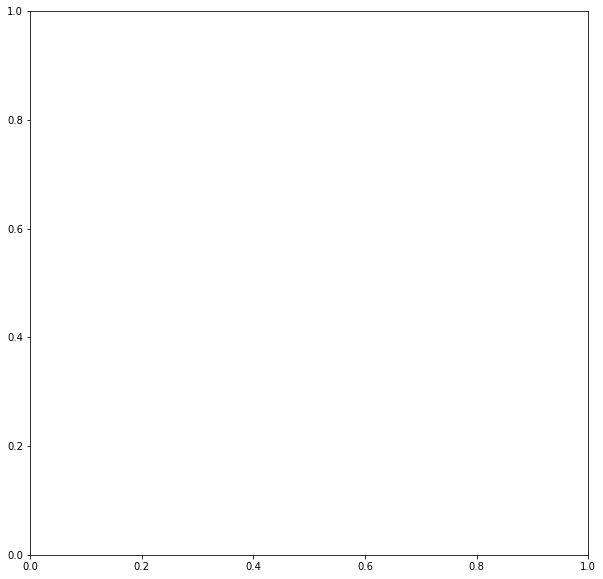

In [13]:
# behaviour reconstruction
# plt.figure(figsize=(6,6));
# plot_behaviour(b_t, test_behavioural_data, direction_index_test, num=20)
# plot_behaviour(b, behavioural_data, direction_index_train)
# behaviour reconstruction
plt.figure(figsize=(10,10));
# plot_behaviour(b, behavioural_data, direction_index_train, num=80)
ax = plt.subplot(111)
for i in range(0,22,3):
    plot_single_behaviour(b_t, test_behavioural_data, direction_index_test, i)

In [ ]:
direction_index_test

In [ ]:
Xt = np.transpose(b_t, (0,2,1)).reshape((b_t.shape[0], -1))
yt = np.transpose(test_behavioural_data, (0,2,1)).reshape((test_behavioural_data.shape[0], -1))
print('R2 score behaviour: {:.3%}'.format(r2_score( yt, Xt)))

# Decoder weights

BehaviouralDense
3 2


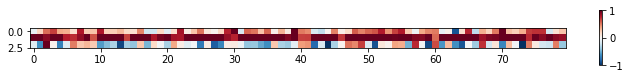

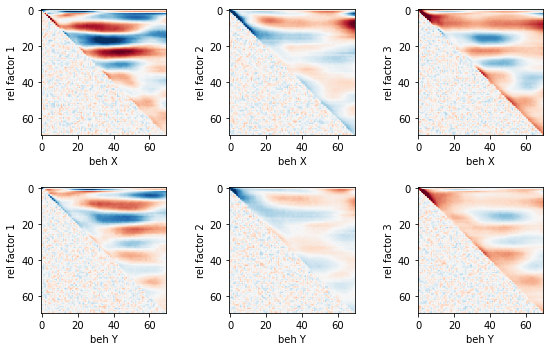

In [74]:
# neural decoder
plt.figure(figsize=(12,1))
plt.imshow((model.neural_dense._trainable_weights[0]),vmin=-1,vmax=1,cmap=plt.cm.RdBu_r)
plt.colorbar()
# behaviour decoder
plot_behaviour_weights(model)